<a href="https://colab.research.google.com/github/frankausberlin/notebook-collection/blob/main/neuralnetworknotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Neural Network Notebook

This is a little cheat sheet to describe the essence of what is called a (**feed forward**) **neural network**.

To understand you have to know some basic concepts which you can find around a bunch of keywords - these are the most important: 

<table width='600'>
<tr><td><p><b>Perceptron<br><br>Parameter</td><td><p><b>Data<br><br>Batches</td><td><p><b>Layer<br><br>Model</td><td><p><b>Training<br><br>Optimizer</td><td><p><b>Loss<br><br>Metric</td></tr>
<tr><td colspan=5>In the following, further <b>keywords</b> are shown in bold type.</td></tr>
</table><br>

I use Pytorch as library. The self-made classes serves to improve understanding. These are limited to the basic functionality and are to be seen as excerpts from the library classes.


# Perceptron & Parameter

<table>
<tr><td>
<img src='https://drive.google.com/uc?id=1cehK_fxj8vtBX1df3aKWF6RSOygzIAiR' width="300">
</td><td>

* A Perceptron gets a **stimulation** $s()$ and do an **activation** $a()$.<br><br>
* The stimulation is a function which maps a lot of x to one y.<br> 
$y=s(x_1,x_2,...,x_n)$<br><br>
* The Perceptron provides **parameters** for that function: **weights**<br> for every x and one **bias**. <br>$y=x_1w_1+x_2w_2+...+x_nw_n+b$<br><br>
* The activation is an other function that gets the result of the<br>stimulation and bring it in a special form (**sigmoid**, **ReLU** etc.).<br>$y = a(s(x))$<br>
</td></tr>
<tabel>

<table><tr></tr><tr><td><img src='https://drive.google.com/uc?id=1wpQFjcKY7jrAPXr5yUF_spOn4eK9yjDB' width="12"></td><td>threshold symbol &emsp;&emsp;'$\bullet$': dot symbol ($x\bullet w+b$; in python: <i>x@weights + bias)</i></td></tr></table>


In [ ]:
from torch import randn, tensor, sigmoid, manual_seed
manual_seed (0)

class Perceptron:
  bias, weights, activation = None, None, None

  def __init__(self, signals, activation=lambda x:x):
    self.weights, self.bias, self.activation = randn (signals), randn (1), activation

  def __call__ (self,x): 
    return self.activation ( x@self.weights + self.bias )

# usage
p = Perceptron (2,sigmoid)
x = tensor ([1.0, 0.0])
p(x)

tensor([0.3457])

# Data & Batches

In **supervised** learning you have **datasets**. That are pairs of input data with its **labels**. The input data are also called **features**. 

* The features and labels must often be converted into a special format (**normalization**, **categories**, **scaling** etc.)
* To train a neural network we need the data in a special structur: the **batches**.
* A batch is a small chunk of data set with a defined **batch size**, mostly shuffled.
* The batch is the input for one **step** of the optimization process.

**Example Data**

* As example we use the **mnist** dataset. It includes 60000 **training** and 10000 **validation** datasets.
* The input are 28x28 pixel pictures of hand written digits and the corresponding label (a number between 0 and 9).
* The labels (or expected) are numbers and will be **one-hot-encoded**. That means:
>0 --> 1000000000<br>7 --> 0000000100 usw.



first image x[0]: (28, 28)


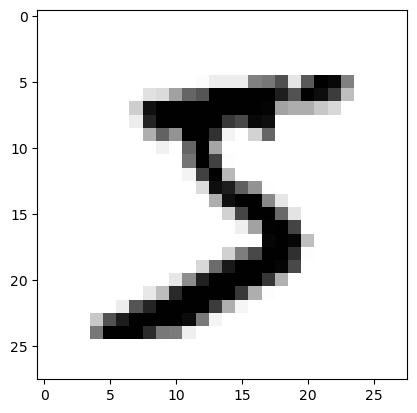

y[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (the label: 5)

generate 600 batches with a size of 100
first batch (x, y): (torch.Size([100, 784]), torch.Size([100, 10]))
last  batch (x, y): (torch.Size([100, 784]), torch.Size([100, 10]))


In [ ]:
import                       random, torch, numpy as np
from matplotlib      import  pyplot as plt
from torchvision     import  datasets

class Batches:
  batches    = None
  pos        = 0

  def __init__(self, XY, batchSize=-1):
    complete, self.batches, self.pos = list(zip(*XY)), [], 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    random.shuffle (complete)
    if batchSize <= 0:
      (x,y) = zip (*complete)
      self.batches.append ( ( torch.tensor(np.array(x),device=device).reshape((len(x),-1)).float(), 
                              torch.tensor(np.array(y),device=device).reshape((len(y),-1)).float() ) )
    else:
      for p in range (0,len(complete),batchSize):
        (x,y) = zip (*complete[p:p+batchSize] ) if p+batchSize < len(complete) else zip (*complete[p:])
        self.batches.append ( ( torch.tensor(np.array(x),device=device).reshape((len(x),-1)).float(), 
                                torch.tensor(np.array(y),device=device).reshape((len(y),-1)).float() ) )

  def __iter__(self):                   self.pos = 0; return self
  def __next__(self): 
    if self.pos < len (self.batches):   self.pos += 1; return self.batches[self.pos-1]
    else:                               self.pos  = 0; raise StopIteration

# mnist data
ds_train = datasets.MNIST(root="data", train=True, download=True)
ds_test  = datasets.MNIST(root="data", train=False, download=True)
train    = ds_train.data.numpy(), np.eye(10)[ds_train.targets.numpy()]
test     = ds_test.data.numpy(),  np.eye(10)[ds_test.targets.numpy()]
x, y     = train

# first image and label
plt.imshow (x[0], cmap='binary')
print ('first image x[0]:',x[0].shape)
plt.show ()
print ('y[0]:',y[0],f'(the label: {np.where (y[0] == 1.)[0][0]})')

# convert data to batches
batches       = Batches (train, 100)
x, y          = next (batches)
for count, b in enumerate(batches): pass
print (f'\ngenerate {count+1} batches with a size of {len(x)}',f'first batch (x, y): {x.shape, y.shape}',sep='\n')
x,y = b
print (f'last  batch (x, y): {x.shape, y.shape}',sep='\n')

# Layer & Model

There are several ways to implement a perceptron. In the stand-alone version you can put the activation in the Perceptron class. However, if you want a Multi Layer Perceptron (**MLP**), it's better to put them in the Layer class or even provide your own Layer class for it.

<table>
<tr><td>
<img src='https://drive.google.com/uc?id=1CHMToYHABzq5zi0yy3wImEHeInbkaiMG' width="600">
</td><td>

* The model has one **input** layer, several **hidden** layer<br> and one **output** layer.<br><br>
* The input layer is not really a layer, it means the input<br> values aka **signals**.<br><br>
* A layer represents one or more **Perceptrons**. Each of<br> them get the input values.<br><br>
* The ouptuts of the perceptrons in a layer are the input<br> values for the perceptrons in the next layer.<br> This principle is called <b>feed forward</b>.<br><br>
* This is how it looks:

>```python
x = torch.tensor ([1.0, 2.0]).to('cuda')
#
""" pytorch version """
from torch.nn import Linear, Sequential, Sigmoid
model = Sequential( Linear (2,1), Sigmoid() ).to('cuda')
y = model (x)
#
""" self-made version """
from torch import sigmoid
model = Model ( Perceptrons (2,1,sigmoid) )
y = model (x)
```
</td></tr>
<tr><td colspan=2>
ps. The <b>deep</b> in Deep Learning means a large number of layers.</td></tr>
<tr></tr>
<tr><td colspan=2>

The code below shows how it works.
</td></tr>
</tabel>
<tr></tr>


In [ ]:
import torch
from torch import randn, tensor, sigmoid, manual_seed, stack, squeeze

manual_seed (0)

class Perceptrons:
  weights, bias, activation = None, None, None

  def __init__(self, signals, count=1, activation=lambda x:x):
    self.activation   = activation
    device            = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
    #                   transpose: ([signals,count]) => ([count,signals]).T
    self.weights      = randn ([signals,count], requires_grad=True, device=device)  
    self.bias         = randn ([count],         requires_grad=True, device=device)

  def __call__(self, x): return self.activation ( x@self.weights + self.bias )


class Model:
  layers = None

  def __init__(self, *layers):  self.layers = layers

  def __call__(self, x): 
    for l in self.layers: 
      x = l(x)
    return x

  def parameters(self):         
    for l in self.layers: yield (l.weights); yield (l.bias)

m = Model (Perceptrons(2,1,sigmoid))
x = tensor ([1.0,2.0]).to('cuda')
y = m(x)
y

tensor([0.1687], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Training & Optimizer
In the training you do a **prediction** and compare that with the **expected**. We agree on the following terminology:<br>
>$\boldsymbol{\large{y = predicted = target}=}$ ```y``` <br>
$\boldsymbol{\large{\hat{y} = expected = actual}=}$ ```y_```<br>

<table><tr><td>
<img src='https://drive.google.com/uc?id=1oPqWbq6C-DVn2oQ5HzG-NwynY-Vch16u'>
</td><td><p>

* The optimizer takes a batch of data and calculates for each<br> dataset in it the change values for all parameters of the model.<br><br>
* The **loss** function uses the predicted and the expected values to calculate<br> an error, which is used to determine the change value. <br><br>
* The **gradient** is the partial derivative of the loss function with<br> respect to a single parameter.<br><br>
* The gradient determines the direction (+ or -) of the weight change,<br> the **learning rate** the size of the change.<br><br>
* It adds up the change values and finally changes the parameters.<br> This is called the optimization **step**.<br><br>
* The changes aim to improve the results of the model.This <br>optimization process is called **training**. <br><br>
* If all batches are completely processed, we speak of a <br>training **epoch**.
</td width="400"></tr>
</table>




In [ ]:
from torch import sigmoid, randn, tensor, manual_seed, stack, squeeze, nn as nn
from torch.nn import functional as F

class Optimizer:
  params, lr = None, None
  def __init__(self,params,lr): self.params,self.lr = list(params),lr

  def step(self, *args, **kwargs): 
    for p in self.params: 
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs): 
    for p in self.params: p.grad = None 


def training(epochs, model, batches, optimizer, loss_fn, metric=lambda a,t:''):
  for epoch in range(epochs):
    for x, y_ in batches:
      y               = model (x)
      loss            = loss_fn (y, y_) # the loss is base for backward
      optimizer       . zero_grad ()
      loss            . backward ()
      optimizer       . step ()

    if not epoch%10:  print (epoch, loss.item(), metric (y,y_)) # the metic is not
  print (epoch, loss.item(), metric (y,y_))    

m = Model (Perceptrons (28*28, 100, sigmoid), Perceptrons (100, 10) )

print ('only a loss function is missing for training - so let\'s look to the parameters\n')
print ('the parameters() funtction returns a generator, it alternately delivers weights and bias\n')
for p in m.parameters(): print (p.shape)

only a loss function is missing for training - so let's look to the parameters

the parameters() funtction returns a generator, it alternately delivers weights and bias

torch.Size([784, 100])
torch.Size([100])
torch.Size([100, 10])
torch.Size([10])


# Loss & Metric

The **loss function** is used in training. It must be able to recognize by what amount the change in parameters has improved or degraded the model. The key **difference between loss and metric** is: the loss function is the basis for the **backward** function and is involved in the calculation of the change values - the metric function is not, it evaluates the model after an optimization step or after an epoch. The backward function is a **backpropagation algorithm** which implements the **delta rule**. I would like to mention here the **universal approximation theorem**, which is one of the theoretical foundations of **machine learning**.

* Imagine you have the picture of a three ($x$) with its label ($\hat y$, expected) and you do a prediction ($y$, predicted):<br>
<table>
<tr><td><p>expected: [</td><td>0.</td><td>0.</td><td>0.</td><td><b>1.</b></td><td>0.</td><td>0.</td><td>0.</td><td>0.</td><td>0.</td><td>0.</td><td><p>]</td></tr><tr></tr>
<tr><td><p>predicted: [</td><td>0.1</td><td>0.2</td><td>0.1</td><td><b>0.8</b></td><td>0.1</td><td>0.3</td><td>0.4</td><td>0.2</td><td>0.1</td><td>0.3</td><td><p>]</td></tr>
</table>
* We can implement a loss function that works like this:<br>
>```np.where (expected==1, 1-predicted, predicted)```<br><br>
This code snippet generate error values by taking elementwise the expected and:<br>
>* when the expected is zero the predicted value is the error value. (consider: first predicted is 0.1 away from the expected 0)
>* when the expected is one the error is 1-predicted value. (consider: the fourth predicted is 0.8 - that means it is 0.2 away from the expected 1)
>* This only works with values between 0 and 1 (sigmoid).
<table><tr><td><p>error: [</td><td>0.1</td><td>0.2</td><td>0.1</td><td><b>0.2</b></td><td>0.1</td><td>0.3</td><td>0.4</td><td>0.2</td><td>0.1</td><td>0.3</td><td><p>]</td></tr></table>

* Finaly we can use that snippet and calculate the mean.<br>
```python
predicted = predicted.sigmoid () # to ensure that all values are between 0 and 1
np.where (expected==1, 1-predicted, predicted).mean() # = 0.2
```
We have a loss function.<br><br>


The **metric** function measures the performance of the model - i.e. what percentage is correct. This is easy:

$$
\frac{<count \quad corrects> \cdot \; 100}{<count \quad total>}
$$

* With the snippet "```argmax( ... )```" the one-hot-encoded values will be converted in to a number.
```python
sum( [argmax(y_) == argmax(y) 
        for y_, y in zip (expected,predicted) ] ).item()
 * 100 / len(actual)
```
* Now we can implement a metric called batch_accuracy:
```python
batch_accuracy (predicted, expected)
```

In [ ]:
from torch import argmax 

def mnist_loss (predicted, expected):
  predicted = predicted.sigmoid ()
  return torch.where (expected==1, 1-predicted, predicted).mean()

def batch_accuracy (predicted, expected):
  return round( sum( [argmax(y_) == argmax(y) 
                      for y_, y in zip (expected,predicted)] ).item()
                * 100 / len(predicted), 2 )
  

m = Model (Perceptrons (28*28, 100, sigmoid), Perceptrons (100, 10) )
b = Batches (train,100)
o = Optimizer (m.parameters(),0.1)

#training(50, m, b, o, mnist_loss, batch_accuracy)
training(100, m, b, o, nn.CrossEntropyLoss(), batch_accuracy)



0 1.1259549856185913 65.0
10 0.45471101999282837 85.0
20 0.5129097700119019 81.0
30 0.37102362513542175 87.0
40 0.27018818259239197 90.0
50 0.27025148272514343 91.0
60 0.24779939651489258 92.0
70 0.2994755804538727 91.0
80 0.280507355928421 92.0
90 0.34005218744277954 91.0
99 0.32663920521736145 89.0


You can see our model is really bad. Well, this model wasn't made to perform well, it was made to show how neural networks work. For a usable mnist model we need a convolutional neural network (**CNN**).